Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# HTGR Micro-Core Quadrant Power

**Input**

- `theta1`: Angle of control drum in quadrant 1 (radians) 
- `theta2`: Angle of control drum in quadrant 1 (radians) 
- `theta3`: Angle of control drum in quadrant 2 (radians)  
- `theta4`: Angle of control drum in quadrant 2 (radians)
- `theta5`: Angle of control drum in quadrant 3 (radians)
- `theta6`: Angle of control drum in quadrant 3 (radians)
- `theta7`: Angle of control drum in quadrant 4 (radians)  
- `theta8`: Angle of control drum in quadrant 4 (radians)  

**Output** 

- `fluxQ1` : Neutron flux in quadrant 1 ($\frac{neutrons}{cm^{2} s}$)
- `fluxQ2` : Neutron flux in quadrant 2 ($\frac{neutrons}{cm^{2} s}$)
- `fluxQ3` : Neutron flux in quadrant 3 ($\frac{neutrons}{cm^{2} s}$)
- `fluxQ4` : Neutron flux in quadrant 4 ($\frac{neutrons}{cm^{2} s}$)

The data provided in `pyMAISE.datasets.load_HTGR` features 751 samples with 8 inputs and 5 outputs. It is the raw data from [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9). Using reactor symmetry, [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9) boosts the sample size to 3004. 

The data set was built using MCNP simulations of the HOLOS-Quad reactor design which is depicted below [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9). This reactor implements modular construction where seperate units can be transported independently and assembled at the plant. The HOLOS-Quad core is a 22 MWt high-temperature gas-cooled microreactor (HTGR) which is controlled by 8 cylindrical control drums. It utilizes TRISO fuel particles contained in hexagonal graphite blocks used as a moderator. These graphite blocks have channels where helium gas can pass through for cooling.

Using machine learning (ML) we aim to predict the neutron distribution given the angles of each of the control drums $\in[0, 2\pi]$. The drums control reactivity by rotating to vary the proximity of $B_4C$, indicated as the red strip on the drums shown below, to the fuel. Perturbations in control drum angle can drastically effect the power distribution in the core. Therefore, predictions of control drum reactivity worth for arbitrary configurations make this problem nontrivial.

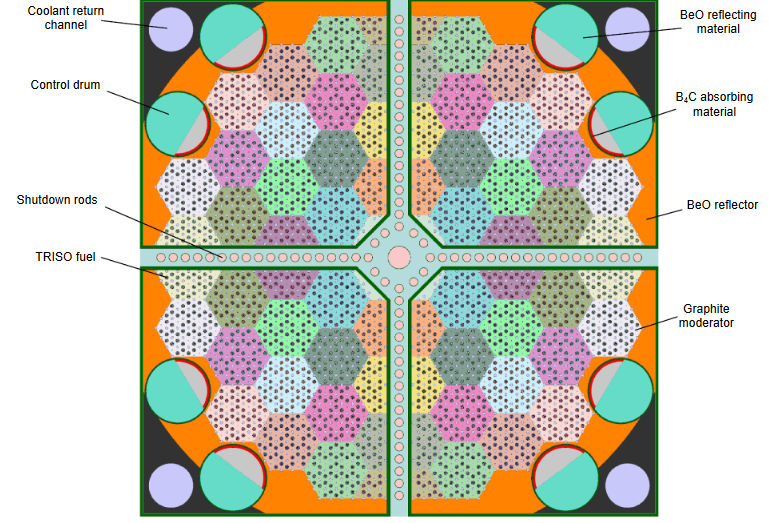

In [2]:
# Importing Packages
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import Normalizer, MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_HTGR
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## Training ML Models on the Raw Data (751 Samples)

Prior to applying symmetry to boost the samples, we evaluate the performance of several ML models on the original data set.

### Preprocessing

We define a regression problem and load the data using `pyMAISE.datasets.load_HTGR`.

In [3]:
# Initializing pyMAISE settings
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Get data
data, inputs, outputs = load_HTGR()

The data consists of 751 samples with 8 inputs:

In [4]:
inputs

<xarray.DataArray (index: 751, variable: 8)>
array([[5.91952603, 2.36950271, 2.92365595, ..., 4.00890489, 4.97036758,
        2.98796636],
       [2.16238049, 0.273624302, 0.927740883, ..., 0.170166579,
        2.12404792, 4.98020926],
       [0.450100101, 0.006300644, 2.51221749, ..., 3.58225182,
        0.280763918, 4.88859544],
       ...,
       [5.96700387, 5.38006724, 5.20081594, ..., 5.65905406, 5.88623681,
        1.86231118],
       [1.34959071, 1.19391098, 4.65205108, ..., 3.19313598, 5.31477415,
        3.84849236],
       [3.60605462, 5.47085601, 1.75207802, ..., 5.07434654, 2.41128238,
        5.64650044]], dtype=object)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 743 744 745 746 747 748 749 750
  * variable  (variable) object 'theta1' 'theta2' 'theta3' ... 'theta7' 'theta8'

and 4 outputs:

In [5]:
outputs

<xarray.DataArray (index: 751, variable: 4)>
array([[2.58e+19, 2.59e+19, 2.67e+19, 2.56e+19],
       [2.55e+19, 2.53e+19, 2.51e+19, 2.51e+19],
       [2.57e+19, 2.58e+19, 2.52e+19, 2.52e+19],
       ...,
       [2.57e+19, 2.53e+19, 2.52e+19, 2.57e+19],
       [2.64e+19, 2.52e+19, 2.59e+19, 2.61e+19],
       [2.51e+19, 2.55e+19, 2.61e+19, 2.55e+19]], dtype=object)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 743 744 745 746 747 748 749 750
  * variable  (variable) object 'fluxQ1' 'fluxQ2' 'fluxQ3' 'fluxQ4'

Below is the correlation for this data set.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

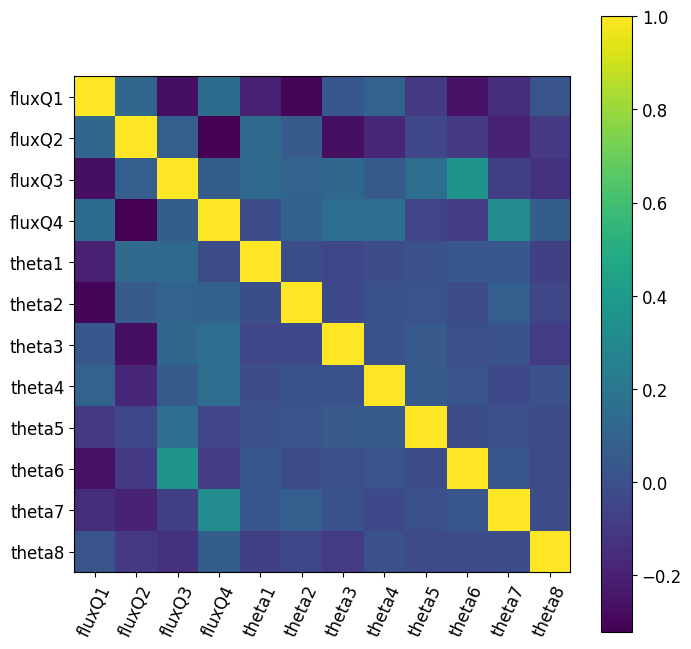

In [6]:
correlation_matrix(data)

We see there are no noticable linear correlations between the inputs and outputs. There are some slightly positive correlations for `theta6` with `fluxQ3` and `theta7` with `fluxQ4`.

We train/test split the data (70%/30%) and scale both the inputs and outputs. The inputs are min-max scaled and the outputs are normalized across each sample.

In [7]:
# Train test split data
train_data, test_data = train_test_split(data=data, test_size=0.30)

theta_cols = [f"theta{i + 1}" for i in range(8)]
flux_cols = [f"fluxQ{i + 1}" for i in range(4)]

# Min-max scaling inputs and normalize and min-max scale outputs
xtrain, xtest, _ = scale_data(train_data.loc[:, theta_cols], test_data.loc[:, theta_cols], MinMaxScaler())
ytrain, ytest, _ = scale_data(train_data.loc[:, flux_cols], test_data.loc[:, flux_cols], Normalizer(norm="l1"))

### Model Initialization

We initialize 6 regression models:

- Linear: `Linear`,
- Lasso: `Lasso`,
- Decision tree: `DT`,
- Random forest: `RF`,
- K-nearest neighbors: `KN`,
- Feedforward dense neural: `FNN`.

All the classical models are initialized as Scikit-learn defaults. The FNN features a dense hidden network with 3 sections: input, hidden, and output. We hyperparameter tune the number of hidden layers and the number of nodes and sublayer for both the input and dense layers. We also tune the learning rate of the Adam optimizer and the batch size. We set epochs to 50 but will increase this after hyperparameter tuning.

In [8]:
# Initializing classical models and define hyperparameter search space for FNN
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=2),
                "units": mai.Int(min_value=25, max_value=300),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Construct pyMAISE.Tuner object
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

### Hyperparameter Tuning

Below we define the search spaces for all the classical models except linear regression. For linear regression we will use only the Scikit-learn default configuration. We utilize a random search with 200 iterations and 5-fold cross validation given their training speed. Given the FNNs are more computationally expensive to train we use Bayesian search with 50 iterations each with 5-fold cross validation. We hope to converge on a performant model based on the Bayesian search.

In [9]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

In [10]:
# Classical model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()

# Run classical model random search
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)

# Run FNN Bayesian search
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 14s]
r2_score: 0.2364815617487211

Best r2_score So Far: 0.4183040916764439
Total elapsed time: 00h 09m 50s
Hyperparameter tuning took 15.339343480269115 minutes to process.


We can visualize the hyperparameter tuning with Bayesian search of the FNN from the convergence plot below.

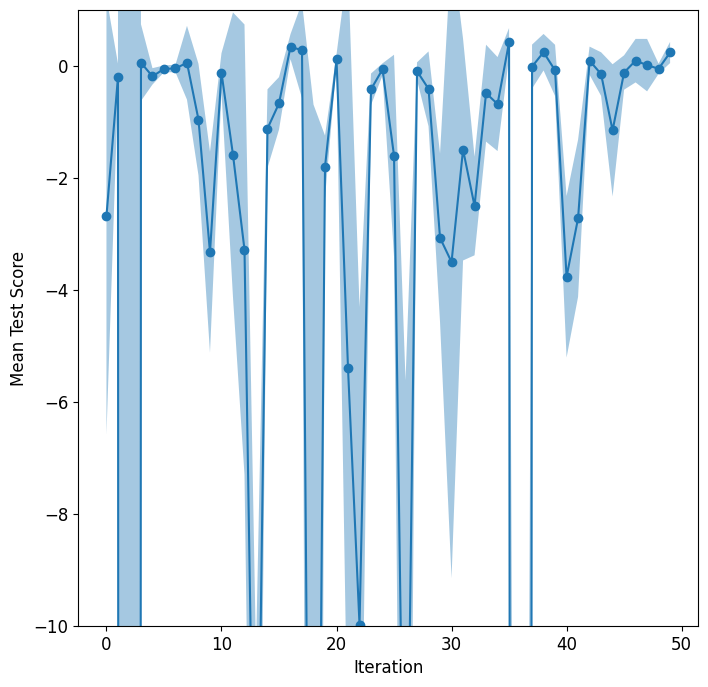

In [11]:
fig, ax = plt.subplots()
ax.set_ylim([-10, 1])
ax = tuner.convergence_plot(model_types="FNN")

We see the Bayesian search finds several configurations close to 0.4 validation $R^2$.

### Model Postprocessing

With the top 5 configurations saved, we can pass these to the `pyMAISE.PostProcessor` for model comparison and analysis. For the FNNs, we increase the epochs to 300 for better performance.

In [12]:
new_model_settings = {"FNN": {"fitting_params": {"epochs": 300}}}

postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
)

Below we computed the performance metrics based on the performance of each model on all quadrants.

In [13]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,FNN,"{'Dense_input_0_units': 218, 'Dense_input_0_su...",0.933737,0.000843,0.000001,0.001060,0.910372,0.001002,0.000002,0.001295
23,FNN,"{'Dense_input_0_units': 133, 'Dense_input_0_su...",0.898337,0.001043,0.000002,0.001317,0.842512,0.001349,0.000003,0.001683
22,FNN,"{'Dense_input_0_units': 235, 'Dense_input_0_su...",0.855671,0.001262,0.000002,0.001557,0.818023,0.001441,0.000003,0.001853
24,FNN,"{'Dense_input_0_units': 188, 'Dense_input_0_su...",0.911109,0.000969,0.000002,0.001226,0.803110,0.001506,0.000004,0.001927
13,RF,"{'criterion': 'absolute_error', 'max_features'...",0.896093,0.001053,0.000002,0.001330,0.597273,0.002172,0.000007,0.002737
11,RF,"{'criterion': 'poisson', 'max_features': 'log2...",0.889729,0.001089,0.000002,0.001371,0.593869,0.002180,0.000008,0.002757
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.862041,0.001227,0.000002,0.001533,0.583309,0.002211,0.000008,0.002794
14,RF,"{'criterion': 'squared_error', 'max_features':...",0.859464,0.001242,0.000002,0.001547,0.582605,0.002205,0.000008,0.002792
15,RF,"{'criterion': 'squared_error', 'max_features':...",0.832581,0.001343,0.000003,0.001690,0.572759,0.002247,0.000008,0.002830
16,KN,"{'leaf_size': 2, 'n_neighbors': 9, 'p': 1, 'we...",1.000000,0.000000,0.000000,0.000000,0.549593,0.002292,0.000008,0.002899


While the most performant models are the FNNs, all models performed poorly on this data set. Most models were overfit with the FNNs offering the best performance. Below are the hyperparameter configurations.

In [14]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00012121903483887521

Model Types: DT
max_depth: 41
max_features: log2
min_samples_leaf: 8
min_samples_split: 5

Model Types: RF
criterion: absolute_error
max_features: None
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 60

Model Types: KN
leaf_size: 2
n_neighbors: 9
p: 1
weights: distance

Model Types: FNN
Dense_input_0_units: 218
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.4625733615653984
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.0008694548913474919
batch_size: 8
Dense_hidden_0_units: 217
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.45142610700924096
Dense_hidden_1_units: 242
Dense_hidden_1_sublayer: Dropout_hidden
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.2418748049662578



To visualize the performance of these models we can use diagonal validation and validation plots as shown below.

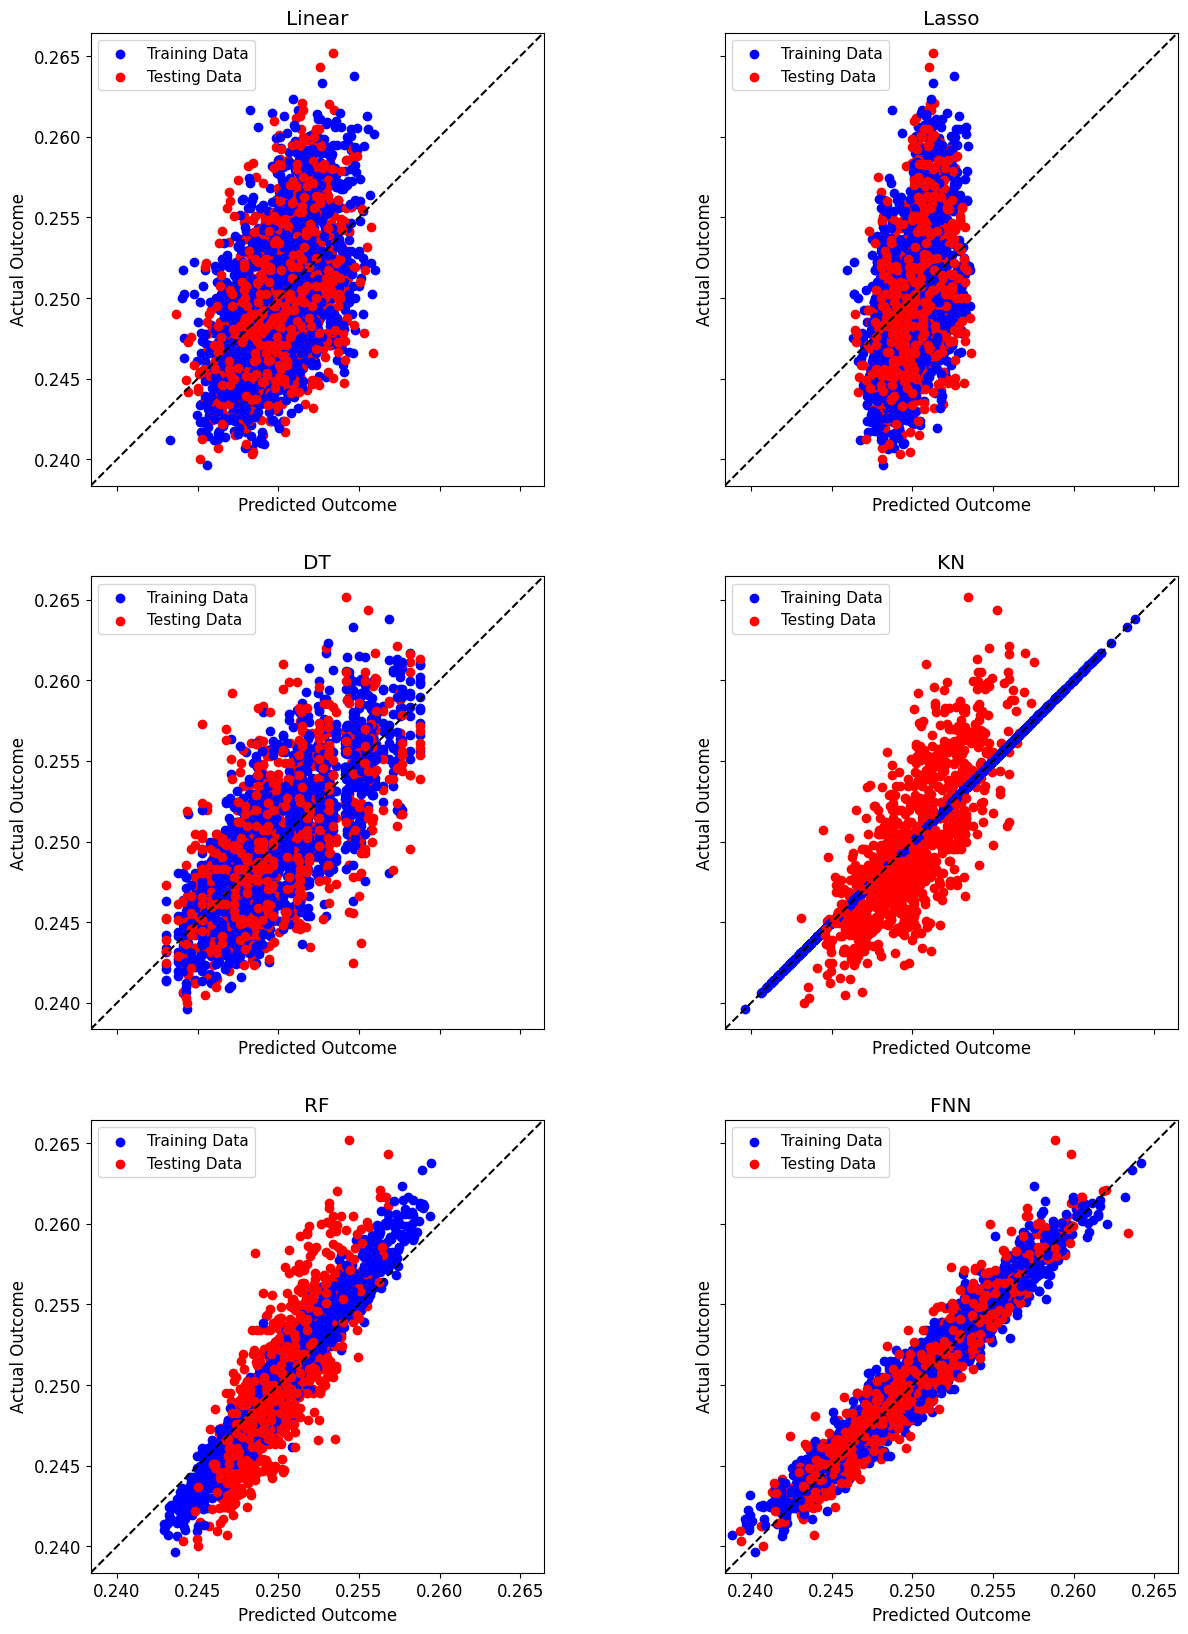

In [15]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

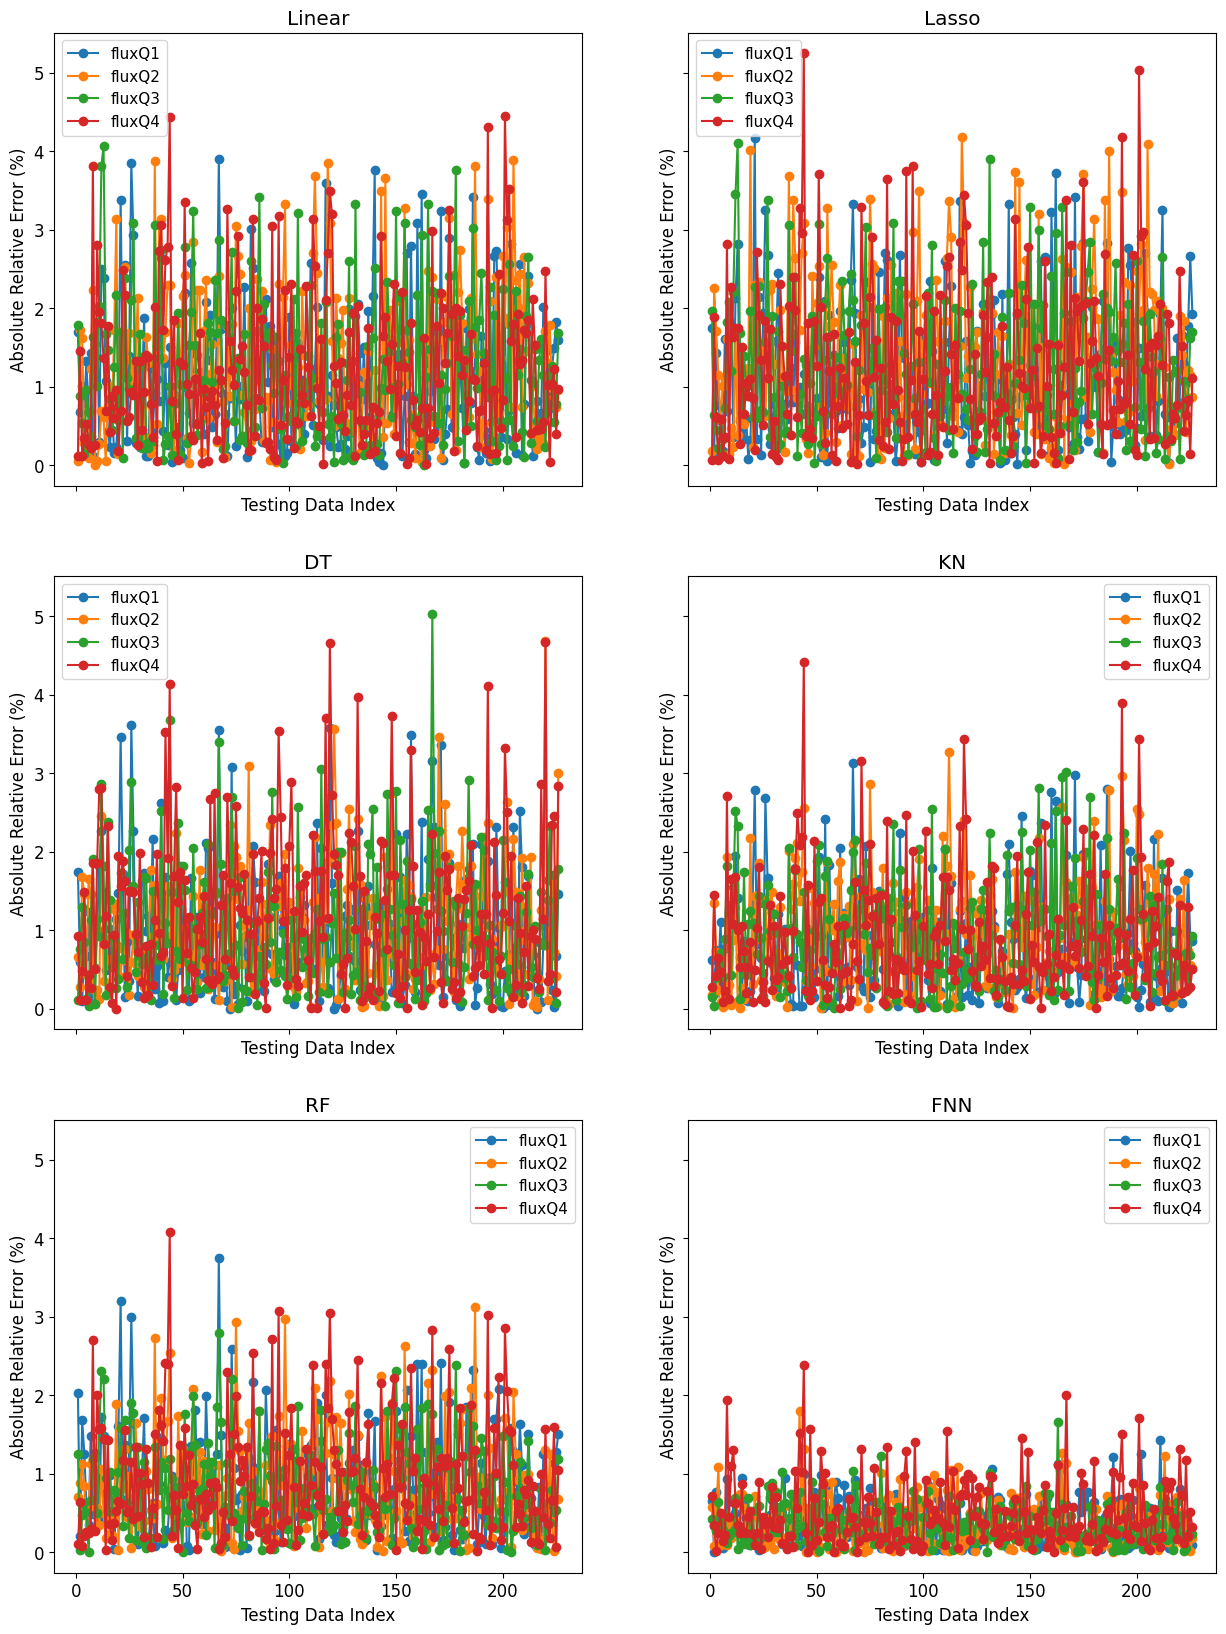

In [16]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

Both the diagonal validation and validation plots agree with the conclusions gathered from the performance metrics. Each of the models overfit to the training data and none offer good performance. Below is the learning curve for the best performing FNN, according to test $R^2$.

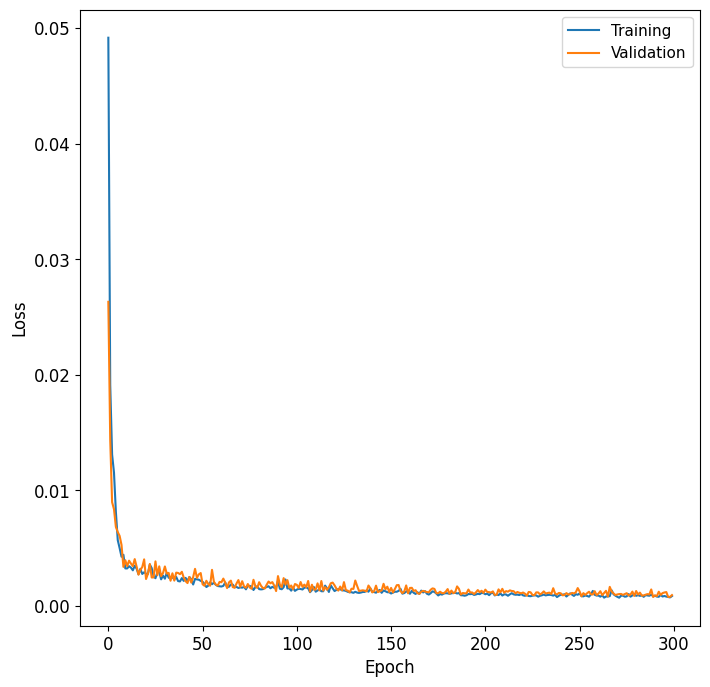

In [17]:
fig, ax = plt.subplots()
ax = postprocessor.nn_learning_plot()

The top performing FNN is not overfit to the training data as shown by the overlapping of the training and validation loss curves.

## Increasing Samples Using Reactor Symmetry (3004 Samples)

We need more data to achieve better results. As shown in [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9), we can apply symmetry rules to multiply the sample size.  

### Preprocessing

To multiply our samples we use the `mult_sym` and `g21` functions from https://github.com/deanrp2/MicroControl/blob/main/pmdata/utils.py. These functions apply reflections over quadrant symmetries to multiply our samples by $4\times$. These functions have been reimplemented and simplified in `mult_samples` using the Xarray data structures pyMAISE uses. Additionally, rather than moving the drum range to $[-\pi, \pi]$, we leave it at $[0, 2\pi]$ to keep consistent with the previous section.

In [18]:
# Credit to mult_sym and g21 from https://github.com/deanrp2/MicroControl/blob/main/pmdata/utils.py#L51
def mult_samples(data):
    # Create empty arrays
    ht = xr.DataArray(
        np.zeros(data.shape), 
        coords={
            "index": [f"{idx}_h" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )
    vt = xr.DataArray(
        np.zeros(data.shape), 
        coords={
            "index": [f"{idx}_v" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )
    rt = xr.DataArray(
        np.zeros(data.shape),     
        coords={
            "index": [f"{idx}_r" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )

    # Swap drum positions
    hkey = [f"theta{i}" for i in np.array([3, 2, 1, 0, 7, 6, 5, 4], dtype=int) + 1]
    vkey = [f"theta{i}" for i in np.array([7, 6, 5, 4, 3, 2, 1, 0], dtype=int) + 1]
    rkey = [f"theta{i}" for i in np.array([4, 5, 6, 7, 0, 1, 2, 3], dtype=int) + 1]

    ht.loc[:, hkey] = data.loc[:, theta_cols].values
    vt.loc[:, vkey] = data.loc[:, theta_cols].values
    rt.loc[:, rkey] = data.loc[:, theta_cols].values

    # Adjust angles
    ht.loc[:, hkey] = (3 * np.pi - ht.loc[:, hkey].loc[:, hkey]) % (2 * np.pi)
    vt.loc[:, vkey] = (2 * np.pi - vt.loc[:, hkey].loc[:, vkey]) % (2 * np.pi)
    rt.loc[:, rkey] = (np.pi + rt.loc[:, hkey].loc[:, rkey]) % (2 * np.pi)

    # Fill quadrant tallies
    hkey = [2, 1, 4, 3]
    vkey = [4, 3, 2, 1]
    rkey = [3, 4, 1, 2]

    ht.loc[:, [f"fluxQ{i}" for i in hkey]] = data.loc[:, flux_cols].values
    vt.loc[:, [f"fluxQ{i}" for i in vkey]] = data.loc[:, flux_cols].values
    rt.loc[:, [f"fluxQ{i}" for i in rkey]] = data.loc[:, flux_cols].values

    sym_data = xr.concat([data, ht, vt, rt], dim="index").sortby("index")
    
    # Normalize fluxes
    sym_data.loc[:, flux_cols].values = Normalizer().transform(sym_data.loc[:, flux_cols].values)
    
    # Convert global coordinate system to local
    loc_offsets = np.array(
        [3.6820187359906447, 4.067668586955522, 2.2155167202240653 - np.pi, 2.6011665711889425 - np.pi, 
         0.5404260824008517, 0.9260759333657285, 5.3571093738138575 - np.pi, 5.742759224778734 - np.pi]
    )

    # Apply correct 0 point
    sym_data.loc[:, theta_cols] = sym_data.loc[:, theta_cols] - loc_offsets + 2 * np.pi

    # Reverse necessary angles
    sym_data.loc[:, [f"theta{i}" for i in [3,4,5,6]]] *= -1

    # Scale all to [0, 2 * np.pi]
    sym_data.loc[:, theta_cols] = sym_data.loc[:, theta_cols] % (2 * np.pi)
        
    return sym_data

Rather than using the `careful_split` function in https://github.com/deanrp2/MicroControl/blob/main/pmdata/utils.py, we apply `mult_samples` to the training and testing data split, `train_data` and `test_data`, in the previous section. This ensures reflected samples are in the same split as their original sample and keeps the split consistent accross sections.

In [19]:
sym_train_data = mult_samples(train_data)
sym_test_data = mult_samples(test_data)
print(f"Multiplied training shape: {sym_train_data.shape}, Multiplied testing shape: {sym_test_data.shape}")

Multiplied training shape: (2100, 12), Multiplied testing shape: (904, 12)


We see our total samples increased from 751 to 3004.

Consistent with [[PRK22]](https://pymaise.readthedocs.io/en/stable/index.html#id9) and the previous section, we normalize the fluxes for each sample. Additionally, we min-max the inputs.

In [20]:
# Min-Max scaling data 
xtrain, xtest, _ = scale_data(sym_train_data.loc[:, theta_cols], sym_test_data.loc[:, theta_cols], MinMaxScaler())
ytrain, ytest, _ = scale_data(sym_train_data.loc[:, flux_cols], sym_test_data.loc[:, flux_cols], Normalizer(norm="l1"))

### Model Initialization and Hyperparameter Tuning

Here we tune the same models with the same hyperparameter search spaces defined in the previous seaction. We also use the same search methods with consistent iterations and cross validation.

In [21]:
# Initialize pyMAISE.Tuner
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

start = time.time()

# Run classical model random search
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)

# Run FNN Bayesian search
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 01m 44s]
r2_score: 0.9223296618097017

Best r2_score So Far: 0.9586285914005674
Total elapsed time: 01h 47m 06s
Hyperparameter tuning took 165.2467850724856 minutes to process.


Once again we can show the convergence of Bayesian search.

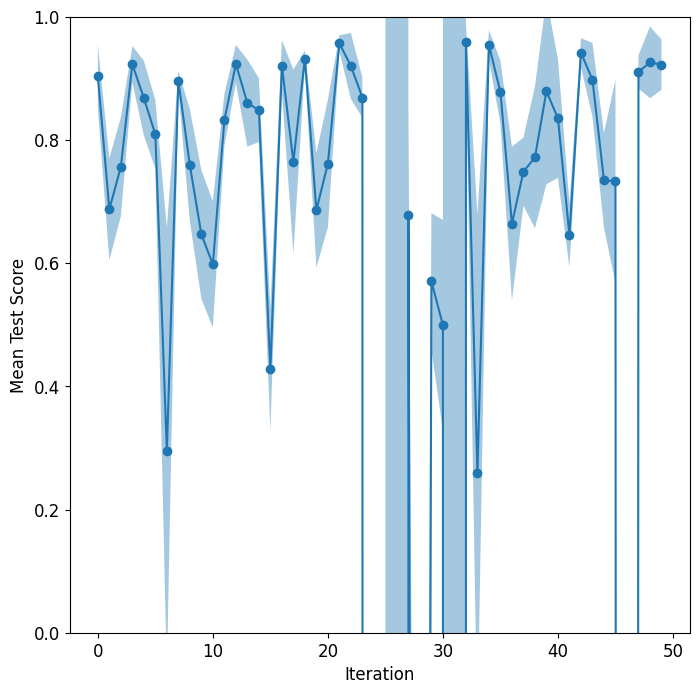

In [29]:
fig, ax = plt.subplots()
ax.set_ylim([0, 1])
ax = tuner.convergence_plot(model_types="FNN")

The Bayesian search provides FNN configurations that perform noticeable better than the FNNs tuned with 751 samples.

## Model Postprocessing

With the models tuned and the top 5 saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. Consistent with before we change the epochs of the FNNs to 300.

In [23]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
)

The average performance metrics are shown below.

In [24]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
23,FNN,"{'Dense_input_0_units': 149, 'Dense_input_0_su...",9.740214e-01,0.000528,4.472103e-07,0.000669,9.734465e-01,0.000561,5.029862e-07,0.000709
22,FNN,"{'Dense_input_0_units': 161, 'Dense_input_0_su...",9.729656e-01,0.000551,4.653843e-07,0.000682,9.708684e-01,0.000599,5.518224e-07,0.000743
25,FNN,"{'Dense_input_0_units': 185, 'Dense_input_0_su...",9.643552e-01,0.000625,6.136081e-07,0.000783,9.590996e-01,0.000697,7.747524e-07,0.000880
24,FNN,"{'Dense_input_0_units': 211, 'Dense_input_0_su...",9.583036e-01,0.000673,7.177840e-07,0.000847,9.553536e-01,0.000732,8.457109e-07,0.000920
21,FNN,"{'Dense_input_0_units': 167, 'Dense_input_0_su...",9.501012e-01,0.000748,8.589840e-07,0.000927,9.522619e-01,0.000767,9.042749e-07,0.000951
16,KN,"{'leaf_size': 7, 'n_neighbors': 8, 'p': 1, 'we...",1.000000e+00,0.000000,0.000000e+00,0.000000,7.178248e-01,0.001826,5.345077e-06,0.002312
11,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",9.069054e-01,0.000992,1.602581e-06,0.001266,7.106783e-01,0.001856,5.480448e-06,0.002341
19,KN,"{'leaf_size': 17, 'n_neighbors': 8, 'p': 1, 'w...",7.540494e-01,0.001632,4.233927e-06,0.002058,7.080118e-01,0.001859,5.530959e-06,0.002352
20,KN,"{'leaf_size': 29, 'n_neighbors': 7, 'p': 1, 'w...",7.637105e-01,0.001603,4.067615e-06,0.002017,7.049372e-01,0.001874,5.589199e-06,0.002364
12,RF,"{'criterion': 'poisson', 'max_features': 4, 'm...",9.122301e-01,0.000969,1.510918e-06,0.001229,7.040408e-01,0.001868,5.606179e-06,0.002368


There is a significant performance increase in the FNNs, random forest models, and k-nearest neighbors models on the testing data set. All FNN models produce training and testing $R^2$ above 0.95 with the best above 0.973. The remaining models did not show significant performance improvement from the increased sample size. All but the FNNs overfit to the training data set.

Below are the optimal hyperparameter configurations based on test $R^2$.

In [25]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00011531191285452646

Model Types: DT
max_depth: 37
max_features: 6
min_samples_leaf: 15
min_samples_split: 13

Model Types: RF
criterion: poisson
max_features: 6
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 122

Model Types: KN
leaf_size: 7
n_neighbors: 8
p: 1
weights: distance

Model Types: FNN
Dense_input_0_units: 149
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.5484389178628002
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.0009557529971998181
Dense_hidden_0_units: 259
Dense_hidden_0_sublayer: Dropout_hidden
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.33803268969428496
batch_size: 16
Dense_hidden_1_units: 36
Dense_hidden_1_sublayer: Dropout_hidden
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.3992280962856989



Once again we can visualize the performance of the optimal models using diagonal validation and validation plots.

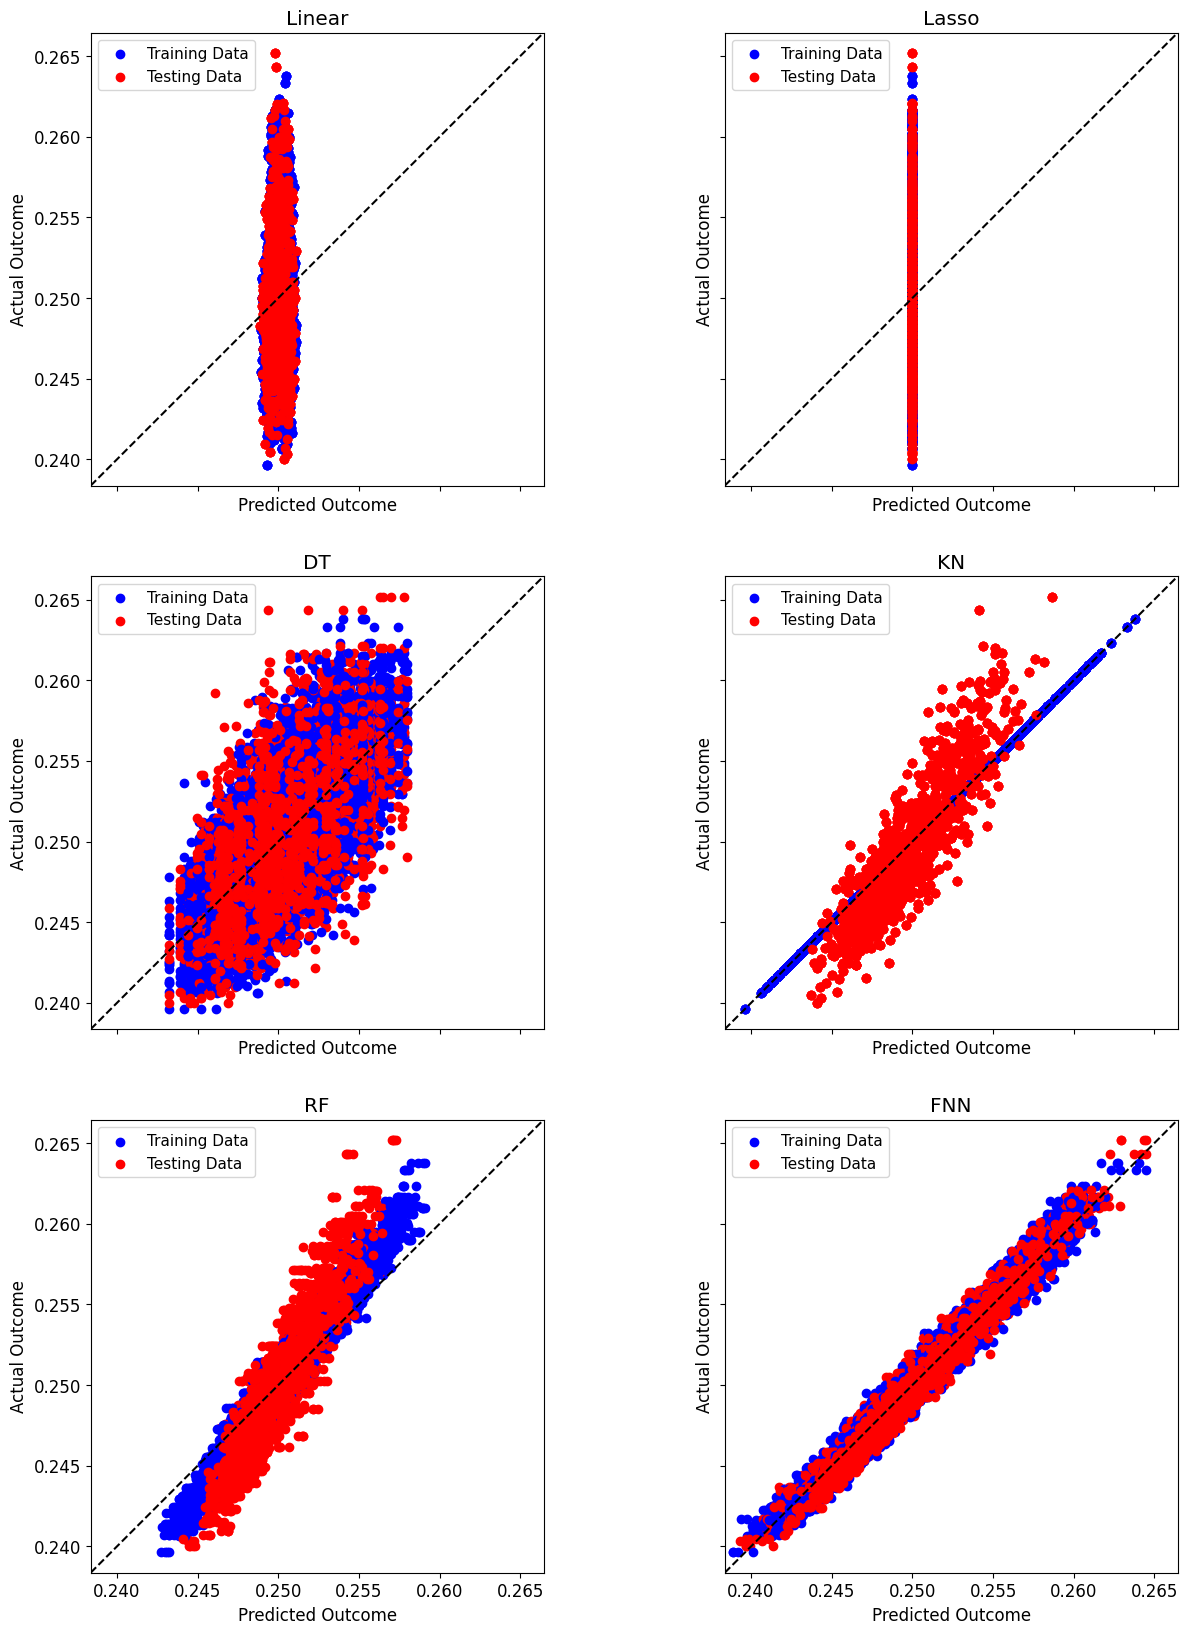

In [26]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

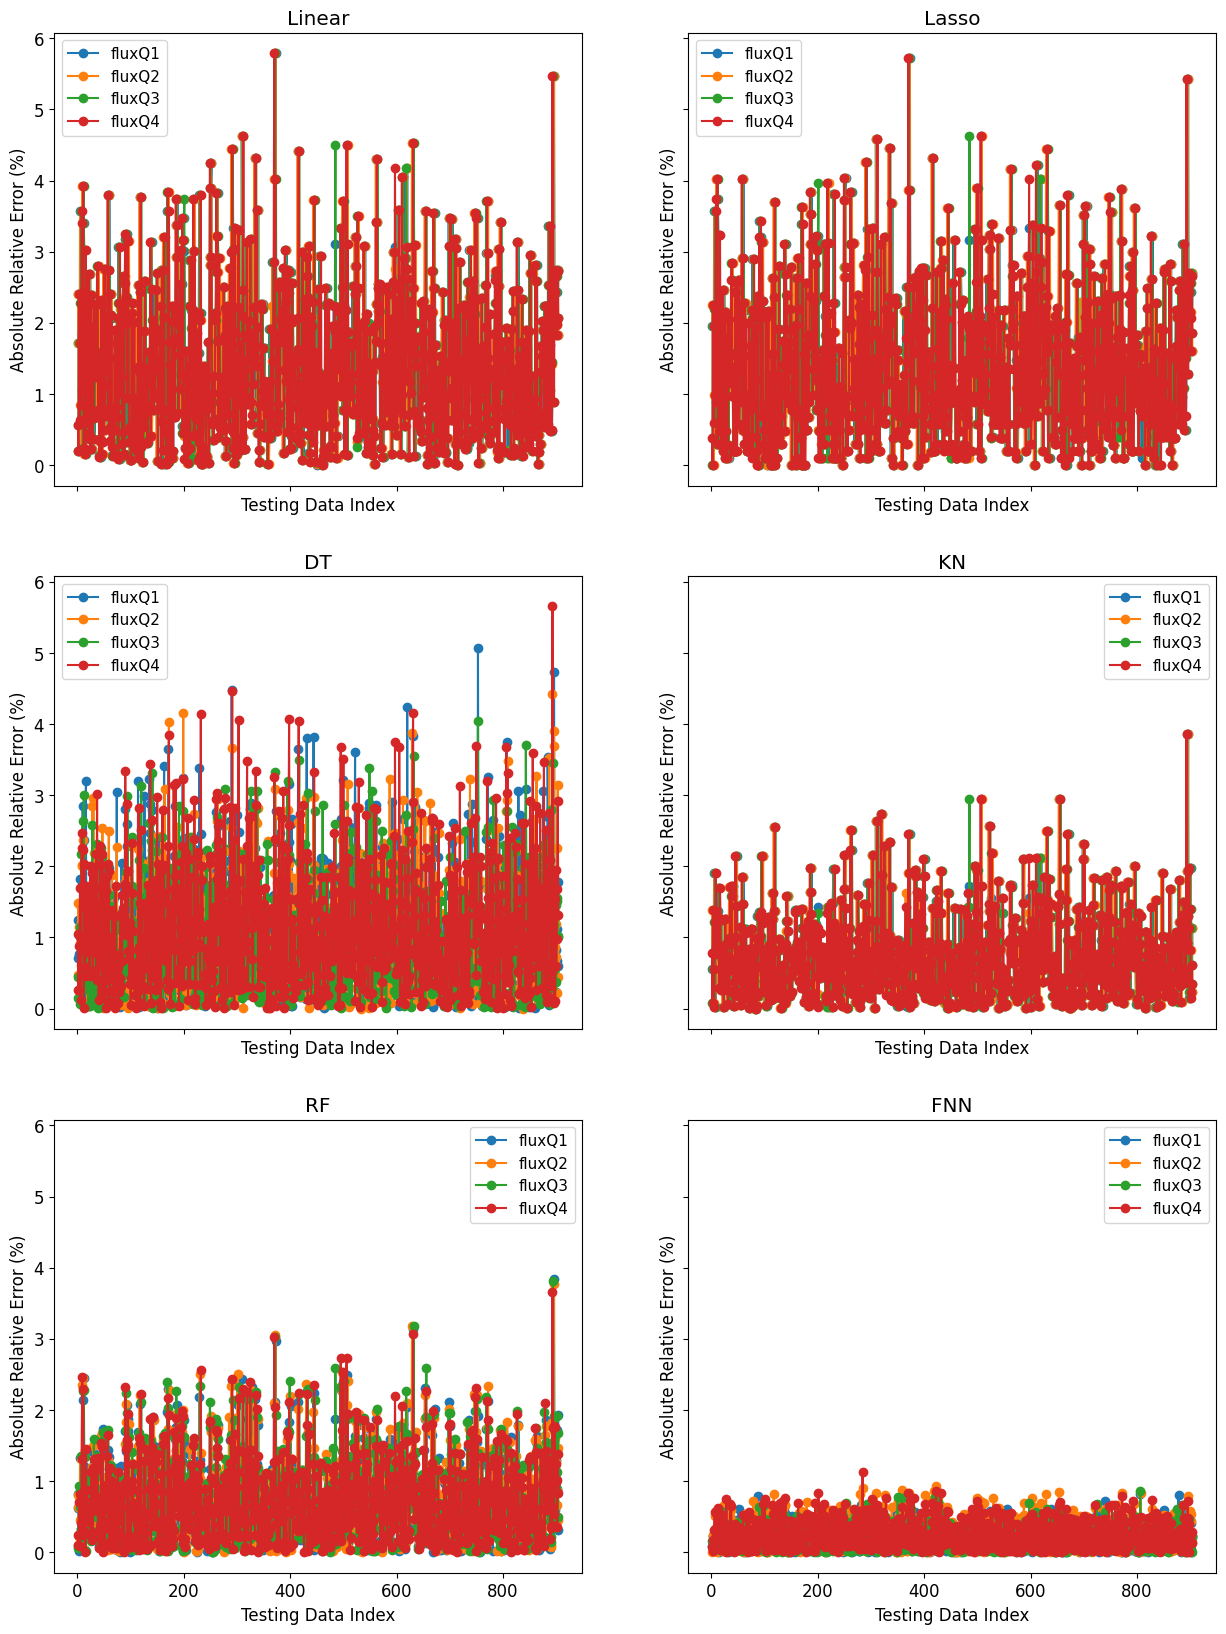

In [27]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

Both plots reaffirm the conclusions from the performance metrics. The FNN model performs significantly better than the other models with most test data predictions off by less than 1%. Below is the learning curve of the optimal FNN model. 

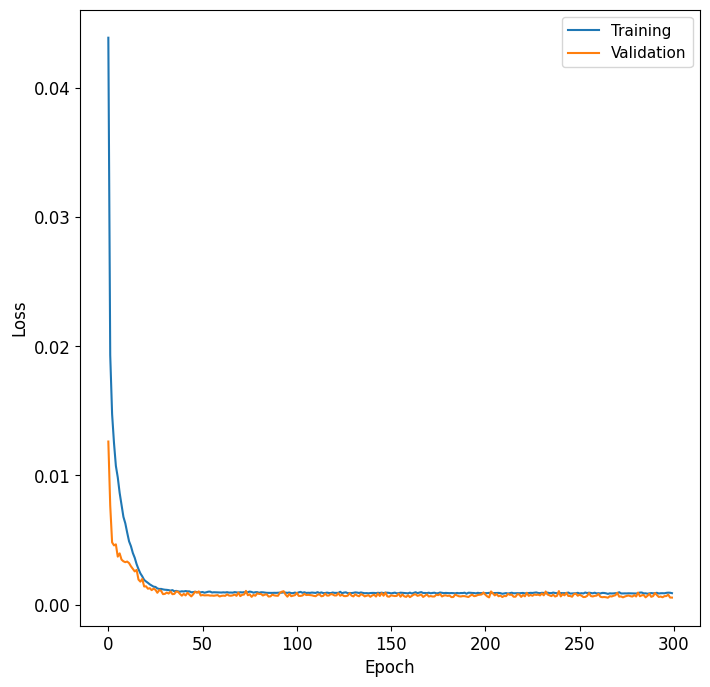

In [28]:
fig, ax = plt.subplots()
ax = postprocessor.nn_learning_plot()

The validation loss curve is consistently below the training curve indicating the FNN is not overfit.

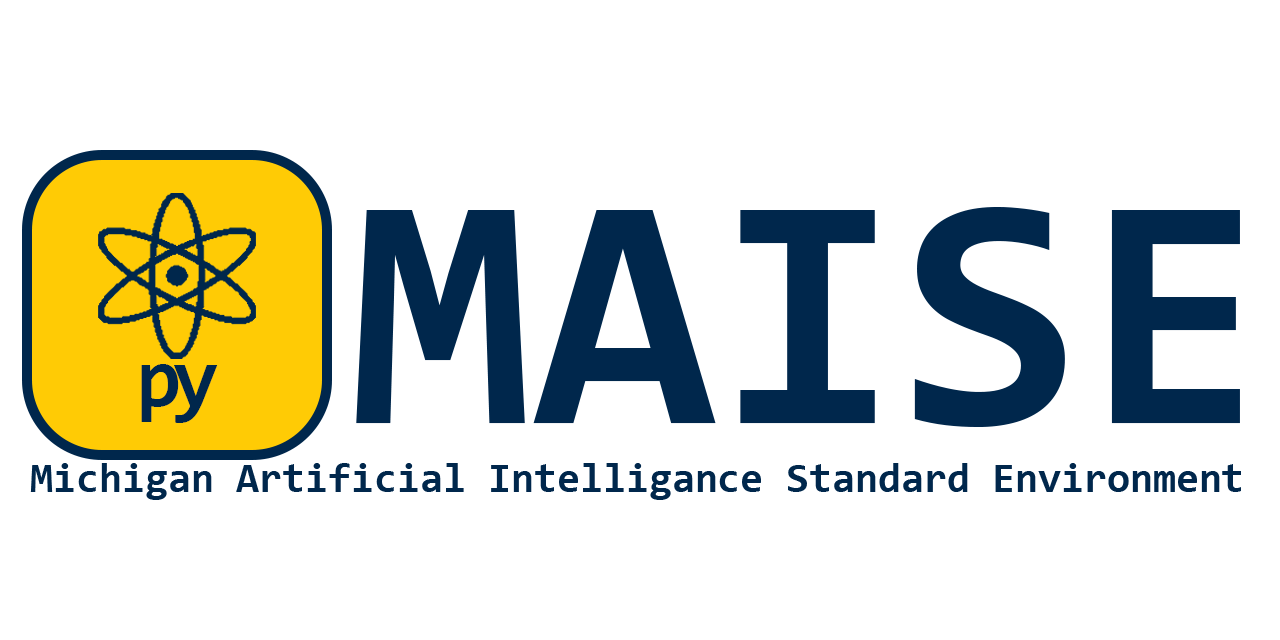